#Stochastic volatility models

##Heston model: theory
One of the main drawback of the BSM is the assumption related to the constant volatility, since we know that the volatility changes through time.

So, there is a list of stochastic volatility model in which we assume that the volatility is stochastic and follows a specific random process.

The first model is the Heston model: we start from the classical stochastic differential equation for the stock price and we extend it to the volatility.
$dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^1$

The volatility, instead, follows this random process:
$
dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^2
$
with the two Brownian motion that are correlated with the coefficient $\rho$, since we need that the correlation structure between the stock price and the volatility is aligned to the real patterns
$\mathbb{E}^P[dW_t^1, dW_t^2] = \rho dt$
It can assume values between -1 and 1.

##Elements
- $\kappa$ is greater than 0 andd it represents the speed of the mean reversion;
- $\theta$ is greater than 0 and it represents the mean reversion level;
- $\sigma$ is the volatility of the variance.

###Girsanov theorem
We start from the **variance process** under the real-world measure $ P $:  

$
dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^2
$

Applying **Girsanov’s theorem**, we know that under the risk-neutral measure $ Q$, we must introduce a **market price of volatility risk** $\lambda(S_t, V_t, t)$, leading to a new Brownian motion:

$
dW_t^2 = d\tilde{W}_t^2 - \lambda(S_t, V_t, t) \frac{dt}{\sigma \sqrt{V_t}}
$

Rewriting the variance process under $ Q $, we substitute:

$
dV_t = \left[ \kappa (\theta - V_t) - \lambda(S_t, V_t, t) \right] dt + \sigma \sqrt{V_t} d\tilde{W}_t^2
$

Now, if we assume that the volatility risk premium is **proportional to variance**, meaning:

$
\lambda(S_t, V_t, t) = \lambda V_t
$

we obtain:

$
dV_t = (\kappa \theta - (\kappa + \lambda) V_t) dt + \sigma \sqrt{V_t} d\tilde{W}_t^2
$

Thus, defining:

$
\kappa^* = \kappa + \lambda, \quad \theta^* = \frac{\kappa \theta}{\kappa^*}
$

we rewrite the variance equation under $ Q $:

$
dV_t = \kappa^* (\theta^* - V_t) dt + \sigma \sqrt{V_t} d\tilde{W}_t^2
$

This transformation ensures that under $Q$, the variance process still exhibits mean reversion, but at an **adjusted speed $\kappa^* $ and level $\theta^*$**.

If we assume **no volatility risk premium**, meaning $\lambda = 0$, then from our definitions:

$
\kappa^* = \kappa + \lambda = \kappa
$

$
\theta^* = \frac{\kappa \theta}{\kappa^*} = \frac{\kappa \theta}{\kappa} = \theta
$

This means that the risk-neutral variance process has the **same parameters as under the real-world measure**, implying that the only adjustment to the dynamics occurs in the stock price equation, where the drift changes from $ \mu$ to $r$ (as expected under risk-neutrality).

##Calibration

In order to simulate the Heston model, like we did in the previous notebook, we can use the Euler discretization and then the maximum likelihood estimation for calibration fitting.

###Euler discretization

Euler discretization is a **numerical method** that simulates paths of the asset price $ S_t $ and volatility $v_t$ using **stochastic differential equations (SDEs)**.

The Heston model consists of two coupled SDEs:

$
dS_t = r S_t dt + \sqrt{v_t} S_t dW_t^S
$

$
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v
$

where $ dW_t^S $ and $dW_t^v$ are correlated Brownian motions with correlation $\rho$.  

The **Euler discretization** approximates the SDEs as:

$
S_{t+\Delta t} = S_t + r S_t dt + \sqrt{v_t dt} S_t Z_t^S
$

$
v_{t+\Delta t} = v_t + \kappa (\theta - v_t)+ \sigma \sqrt{v_t dt} Z_t^v
$

where $Z_t^S$ and $Z_t^v$ are **correlated standard normal variables**.



In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
!pip install --upgrade yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import ncx2
from scipy.integrate import quad
import random
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import ncx2
from scipy.integrate import quad
import random
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [270]:
N_1= norm.cdf
NVDA= yf.Ticker('NVDA')
hist=NVDA.history(period="1y")
log_returns= np.log(hist["Close"].pct_change())
S= hist["Close"].iloc[-1]
S

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


139.22999572753906

In [271]:
expiration= NVDA.options
chosen_date= expiration
expiration[3]

'2025-03-14'

In [272]:
options= NVDA.option_chain(expiration[3])
call_op= options.calls.dropna()
K_list= call_op["strike"].values
t_list=call_op["lastTradeDate"].values
call_op

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,NVDA250314C00050000,2025-02-13 20:17:57+00:00,50.0,85.67,0.0,0.0,0.0,0.0,3,0,0.000010,True,REGULAR,USD
1,NVDA250314C00055000,2025-02-10 16:38:12+00:00,55.0,78.60,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
2,NVDA250314C00060000,2025-02-18 15:05:11+00:00,60.0,80.55,0.0,0.0,0.0,0.0,1,0,0.000010,True,REGULAR,USD
3,NVDA250314C00065000,2025-01-31 15:27:59+00:00,65.0,62.00,0.0,0.0,0.0,0.0,1,0,0.000010,True,REGULAR,USD
4,NVDA250314C00070000,2025-02-12 17:37:27+00:00,70.0,61.78,0.0,0.0,0.0,0.0,37,0,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,NVDA250314C00220000,2025-02-19 20:33:57+00:00,220.0,0.04,0.0,0.0,0.0,0.0,10,0,0.500005,False,REGULAR,USD
66,NVDA250314C00225000,2025-02-18 20:55:03+00:00,225.0,0.04,0.0,0.0,0.0,0.0,11,0,0.500005,False,REGULAR,USD
67,NVDA250314C00230000,2025-02-18 18:39:14+00:00,230.0,0.04,0.0,0.0,0.0,0.0,10,0,0.500005,False,REGULAR,USD
68,NVDA250314C00235000,2025-02-19 19:14:29+00:00,235.0,0.03,0.0,0.0,0.0,0.0,82,0,0.500005,False,REGULAR,USD


In [273]:
def time_to_maturity(expiration, trade_day):
  exp = pd.to_datetime(expiration).tz_localize(None) # Make exp timezone-naive
  trade = pd.to_datetime(trade_day).tz_localize(None) # Make trade timezone-naive
  time_diff = (exp - trade).days
  time_diff = time_diff / 365
  return time_diff

first_time = time_to_maturity(expiration[3], call_op['lastTradeDate'].iloc[0])
times= call_op.apply(lambda row: time_to_maturity(expiration[3],row['lastTradeDate']),axis=1)
times

,0
0,0.076712
1,0.084932
2,0.063014
3,0.112329
4,0.079452
...,...
65,0.060274
66,0.063014
67,0.063014
68,0.060274


In [274]:
T=252
dt=1/252
N=10
random.seed(123)

In [275]:
def heston_vol(kappa, theta, sigma, Z, T,dt,v_0):
  v= np.zeros((T,N))
  v[0,:]=v_0
  for i in range(1,T):
    v[i, :] = np.maximum(v[i-1, :] + kappa * (theta - v[i-1, :]) * dt + sigma * np.sqrt(v[i-1, :] * dt) * Z[i-1,:], 1e-6)
  return v

In [276]:
def stoch_price(S, r, v, Z,dt):
  S_paths= np.zeros((T,N))
  S_paths[0,:]=S
  for i in range(1,T):
    S_paths[i,:]=S_paths[i-1,:]+S_paths[i-1,:]*r*dt + np.sqrt(v[i-1,:]*dt)*S_paths[i-1,:]*Z[i-1,:]
  return S_paths


Then, I need to use the maximum likelihood estimator in order to calibrate the data $\kappa$, $\theta$ and $\sigma$.

MLE is a random variable that is able to maximize the argument of the likelihood function.

For the likelihood function we need the pdf, the observed data and the parametric space of the unknown parameters.

In the specific I need to use

```
stats.norm.pdf()
```
for which I need the mean and the variance.
The volatility sde is modelled through **non-central chi-squared** (ncx²).

A non-central chi-squared distribution arises when summing the squares of independent normal variables, but with a nonzero mean.

The **Heston model** assumes that variance $v_t$ follows a **Cox-Ingersoll-Ross (CIR) process** that converges to **non-central chi-squared**:
$dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t$




In [277]:
initial_params = [0.08,0.02,0.02,0.07,-0.5,1.5]
dZ = np.random.multivariate_normal(mean=[0, 0], cov=[[dt, initial_params[4]*dt], [initial_params[4]+dt, dt]], size=(T-1, N))
Z1 = dZ[:, :, 0]
Z2 = dZ[:, :, 1]
v = heston_vol(initial_params[2], initial_params[1], initial_params[3], Z2, T,dt,initial_params[-1])
S_paths = stoch_price(S, initial_params[0], v, Z1,dt)

<ipython-input-277-c6ff296288f2>:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  dZ = np.random.multivariate_normal(mean=[0, 0], cov=[[dt, initial_params[4]*dt], [initial_params[4]+dt, dt]], size=(T-1, N))


In [278]:
def heston_log_likelihood(params, S, v, dt, T):
      r, theta, kappa, sigma, rho, v_0 = params
      log_likelihood = 0

      for t in range(1, T):
        try:
            c = 2 * kappa / (sigma**2 * (1 - np.exp(-kappa * dt)))
            df = 4 * kappa * theta / sigma**2
            nc = c * v[t-1] * np.exp(-kappa * dt)
            p_v = stats.ncx2.pdf(2 * c * v[t], df, nc)
            mu_q = S[t-1] + (r - 0.5 * v[t-1]) * dt
            sigma_q = np.sqrt(v[t-1] * dt)
            p_q = stats.norm.pdf(S[t], loc=mu_q, scale=sigma_q)

            # Check for invalid values
            if np.isnan(p_v).any() or np.isnan(p_q).any():
                print(f"NaN detected at t={t}")
                print(f"v[t-1]: {v[t-1]}, mu_q: {mu_q}, sigma_q: {sigma_q}")
                return np.inf  # Return a large number instead of NaN

            log_likelihood += np.sum(np.log(p_v + 1e-10)) + np.sum(np.log(p_q + 1e-10))

        except Exception as e:
            print(f"Error at t={t}: {e}")
            return np.inf  # Prevent optimizer from breaking

      return -log_likelihood  # Negative log-likelihood for minimization
bnds_r = ((-10, 10),)  # Bounds for 'r'
bnds_theta = ((0, None),)  # Bounds for 'theta'
bnds_kappa = ((0, None),)  # Bounds for 'kappa'
bnds_sigma = ((0, None),)  # Bounds for 'sigma'
bnds_rho = ((-1, 1),)  # Bounds for 'rho'
bnds_v = ((0, None),)
# Combine bounds into a single sequence of tuples
bounds = bnds_r + bnds_theta + bnds_kappa + bnds_sigma + bnds_rho +bnds_v
result = minimize(heston_log_likelihood, initial_params, args=(S_paths, v, dt, T), bounds=bounds, method="Nelder-Mead")

print("Estimated parameters:", result.x)


NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22822564 139.22822564 139.22822564 139.22822564 139.22822564
 139.22822564 139.22822564 139.22822564 139.22822564 139.22822564], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22828391 139.22828391 139.22828391 139.22828391 139.22828391
 139.22828391 139.22828391 139.22828391 139.22828391 139.22828391], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22817449 139.22817449 139.22817449 139.22817449 139.22817449
 139.22817449 139.22817449 139.22817449 139.22817449 139.22817449], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
N

<ipython-input-278-fb7abdb6d92c>:7: RuntimeWarning: invalid value encountered in scalar divide
  c = 2 * kappa / (sigma**2 * (1 - np.exp(-kappa * dt)))
<ipython-input-278-fb7abdb6d92c>:8: RuntimeWarning: invalid value encountered in scalar divide
  df = 4 * kappa * theta / sigma**2


NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22879622 139.22879622 139.22879622 139.22879622 139.22879622
 139.22879622 139.22879622 139.22879622 139.22879622 139.22879622], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22871558 139.22871558 139.22871558 139.22871558 139.22871558
 139.22871558 139.22871558 139.22871558 139.22871558 139.22871558], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22875048 139.22875048 139.22875048 139.22875048 139.22875048
 139.22875048 139.22875048 139.22875048 139.22875048 139.22875048], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
N

<ipython-input-278-fb7abdb6d92c>:7: RuntimeWarning: divide by zero encountered in scalar divide
  c = 2 * kappa / (sigma**2 * (1 - np.exp(-kappa * dt)))
<ipython-input-278-fb7abdb6d92c>:8: RuntimeWarning: divide by zero encountered in scalar divide
  df = 4 * kappa * theta / sigma**2


NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22870522 139.22870522 139.22870522 139.22870522 139.22870522
 139.22870522 139.22870522 139.22870522 139.22870522 139.22870522], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22870723 139.22870723 139.22870723 139.22870723 139.22870723
 139.22870723 139.22870723 139.22870723 139.22870723 139.22870723], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
NaN detected at t=1
v[t-1]: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5], mu_q: [139.22871135 139.22871135 139.22871135 139.22871135 139.22871135
 139.22871135 139.22871135 139.22871135 139.22871135 139.22871135], sigma_q: [0.07715167 0.07715167 0.07715167 0.07715167 0.07715167 0.07715167
 0.07715167 0.07715167 0.07715167 0.07715167]
N

## Pricing Nvidia option through Heston model

The PDE governing the price $ U(S, v, t) $ of a derivative under the Heston model is:

$
\frac{\partial U}{\partial t} + (r - q) S \frac{\partial U}{\partial S} + \kappa (\theta - v) \frac{\partial U}{\partial v} + \frac{1}{2} v S^2 \frac{\partial^2 U}{\partial S^2} + \frac{1}{2} \sigma^2 v \frac{\partial^2 U}{\partial v^2} + \rho \sigma v S \frac{\partial^2 U}{\partial S \partial v} - r U = 0,
$

**Parameters:**
- $ S $: Asset price.
- $v $: Variance (volatility squared).
- $r$: Risk-free rate.
- $q$: Dividend yield.
- $\kappa$: Mean reversion speed of variance.
- $\theta$: Long-term mean variance.
- $\sigma$: Volatility of volatility.
- $\rho $: Correlation between asset price and variance.

---
The price of a European call option is:

$
C(S, v, t) = S e^{-q(T-t)} P_1 - K e^{-r(T-t)} P_2, $

where $P_1$ and $P_2$ are probabilities derived from the characteristic functions of the Heston model. These probabilities are computed via Fourier inversion:

$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_0^\infty \text{Re}\left[ \frac{e^{-i u \ln K} \phi_j(u)}{i u} \right] du \quad (j = 1, 2).
$

**Characteristic Functions $\phi_j$:**

$
\phi_j(u, S, v, t) = \exp\left[ C_j(\tau, u) + D_j(\tau, u) v + i u \ln S \right],
$

where $\tau = T - t $, and $ C_j, D_j $ are given by:

$
\begin{aligned}
C_j(\tau, u) &= r i u \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i u + d_j) \tau - 2 \ln\left( \frac{1 - g_j e^{d_j \tau}}{1 - g_j} \right) \right], \\
D_j(\tau, u) &= \frac{b_j - \rho \sigma i u + d_j}{\sigma^2} \left( \frac{1 - e^{d_j \tau}}{1 - g_j e^{d_j \tau}} \right), \\
d_j &= \sqrt{(\rho \sigma i u - b_j)^2 - \sigma^2 (2 u_j i u - u^2)}, \\
g_j &= \frac{b_j - \rho \sigma i u + d_j}{b_j - \rho \sigma i u - d_j}.
\end{aligned}
$

**Parameters for $P_1$ and $P_2 $:**
- For $P_1$: $u_1 = 0.5, \, b_1 = \kappa - \rho \sigma $.
- For $P_2$: $ u_2 = -0.5, \, b_2 = \kappa $.


In [279]:
K=call_op["strike"][0]

In [280]:
v_t=v[-1,-1]
v_t

1.458992742828737

In [281]:
def heston_characteristic_function(tau, S, v, r, kappa, theta, sigma, rho, j):
    i = 1j
    if j == 1:
        b = kappa - rho * sigma
        u=0.5
    elif j == 2:
        b = kappa
        u=-0.5


    d = np.sqrt((rho * sigma * i * u - b)**2 - sigma**2 * (2 * u * i * u - u**2))
    g = (b - rho * sigma * i * u - d) / (b - rho * sigma * i * u + d)

    C = (r * i * u * tau +
         (kappa * theta / sigma**2) *
         ((b - rho * sigma * i * u - d) * tau - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g))))

    D = ( (b - rho * sigma * i * u - d) / sigma**2 *
        ( (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau)) ))

    phi = np.exp(C + D * v + i * u * np.log(S))
    return phi

In [282]:
def call_price(S,P1,P2,T,r,K):
  call_price = S * np.exp(-0*T) * P1 - K * np.exp(-r * T) * P2
  return call_price

In [283]:
def compute_Pj(j, K, S, v, r, kappa, theta, sigma, rho, tau):
    phi_j = lambda u: heston_characteristic_function(tau, S, v, r, kappa, theta, sigma, rho, j)
    integral, _ = quad(lambda u: np.real(np.exp(-1j * u * np.log(K)) * phi_j(u) / (1j * u)), 0, np.inf)
    return 0.5 + (1 / np.pi) * integral

# Define objective function for optimization
def optimal_values(params, S, K, T, last_price):
    r, kappa, theta, sigma, rho, v = params
    P1 = compute_Pj(1, K, S, v, r, kappa, theta, sigma, rho, T)
    P2 = compute_Pj(2, K, S, v, r, kappa, theta, sigma, rho, T)
    model_price = call_price(S, P1, P2, T, r, K)
    return (model_price - last_price) ** 2

initial_params = [result.x[0],result.x[2],result.x[1],result.x[3],result.x[4],v_t]
last_price = call_op["lastPrice"].iloc[0]
bnds_r = ((-10, 10),)  # Bounds for 'r'
bnds_theta = ((0, None),)  # Bounds for 'theta'
bnds_kappa = ((0, None),)  # Bounds for 'kappa'
bnds_sigma = ((0, None),)  # Bounds for 'sigma'
bnds_rho = ((-1, 1),)
bnds_v= ((0, None),)
bounds = bnds_r + bnds_theta + bnds_kappa + bnds_sigma + bnds_rho  + bnds_v
optimal_result = minimize(optimal_values, initial_params, args=(S, K, first_time, last_price), bounds=bounds, method="Nelder-Mead")
print("Optimized parameters:", optimal_result.x)

Optimized parameters: [1.00000000e+01 2.15590705e+33 2.43229614e+33 1.58845171e+34
 1.00000000e+00 1.45899274e+00]


In [284]:
phi1=heston_characteristic_function(first_time,S,optimal_result.x[-1],optimal_result.x[0],optimal_result.x[1],optimal_result.x[2],optimal_result.x[3],optimal_result.x[4],j=1)
phi2=heston_characteristic_function(first_time,S,optimal_result.x[-1],optimal_result.x[0],optimal_result.x[1],optimal_result.x[2],optimal_result.x[3],optimal_result.x[4],j=2)
P1 = compute_Pj(1, K, S, optimal_result.x[-1], optimal_result.x[0], optimal_result.x[1], optimal_result.x[2], optimal_result.x[3], optimal_result.x[4], first_time)
P2 = compute_Pj(2, K, S, optimal_result.x[-1], optimal_result.x[0], optimal_result.x[1], optimal_result.x[2], optimal_result.x[3], optimal_result.x[4], first_time)
price=call_price(S,P1,P2,first_time,optimal_result.x[0],K)
price

58.006324329322084

In [285]:
call_op["Heston price"]=call_op.apply(lambda row: call_price(S,P1,P2,time_to_maturity(expiration[3], row["lastTradeDate"]), optimal_result.x[0],row["strike"]), axis=1)
call_op["Heston price"]

,Heston price
0,58.006324
1,57.853034
2,53.639432
3,59.045710
4,53.802075
...,...
65,9.410887
66,9.706627
67,8.375330
68,5.306061


###Volatility surface from the Heston model
- The initial variance $v_0$ and the long-term mean of the variance $\theta$ control the level of the implied volatility curve, that is the second moment;

- The correlation $\rho$ controls the skew of the implied volatility curve, that is the third moment;

- The volatility of the volatility $\sigma$ controls the smile of the implied volatility, that is the fourth moment.

In the Heston model, the cumulative variance is the integral of the instantaneous variance that follows a CIR model.


In [286]:
def black_scholes(S0,K,T,r,sigma,option_type='call'):

  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)

  if option_type == 'call':
      return S0 * N_1(d1) - K * np.exp(-r * T) * N_1(d2)
  else:
      return K * np.exp(-r * T) * N_1(-d2) - S0 * N_1(-d1)


In [287]:
def implied_vol(S0,K,T,r,option_price,option_type="call"):
  payoff= lambda sigma: (black_scholes(S0,K,T,r,sigma,option_type="call") - option_price)**2
  result= minimize_scalar(payoff,method="bounded", bounds=(0,3))
  return result.x if result.success else np.nan


In [288]:
last_price=call_op["lastPrice"][0]

In [289]:
impl_vol=implied_vol(S,K,first_time,optimal_result.x[0],last_price,option_type="call")
impl_vol

0.7919957930163152

In [290]:
implied_volatilities=call_op.apply(lambda row: implied_vol(S, row["strike"], time_to_maturity(expiration[3], row["lastTradeDate"]), optimal_result.x[0],row["Heston price"]), axis=1)
implied_volatilities

,0
0,0.792039
1,0.708207
2,0.733307
3,0.437700
4,0.708167
...,...
65,0.049913
66,0.031400
67,0.052283
68,0.036587


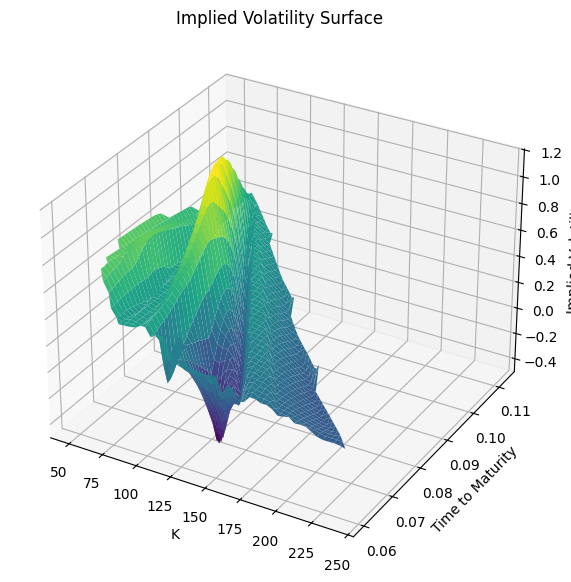

In [291]:
from scipy.interpolate import griddata
x = np.array(K_list)
y = np.array(times)
z = np.array(implied_volatilities)

# Define a regular grid
K_grid = np.linspace(x.min(), x.max(), 50)
T_grid = np.linspace(y.min(), y.max(), 50)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

# Interpolate z onto this grid
Z_mesh = griddata((x, y), z, (K_mesh, T_mesh), method='cubic')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_mesh, T_mesh, Z_mesh, cmap='viridis', edgecolor='none')

# Labels
ax.set_xlabel("K")
ax.set_ylabel("Time to Maturity")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

plt.show()
